## Set-up

In [282]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()

In [283]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()

    return fig, ax

In [284]:
months = ['12']

# Process data

## Data matrix $X$

In [285]:
input_df = pd.read_csv('data/daily_curves.csv', index_col=0)
print(len(input_df))
input_df.head(3)

11653


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,660.975,648.877,658.723,745.817,773.431,828.180,831.509,758.732,669.630,596.548
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,738.739,678.540,666.579,730.333,764.207,819.056,825.176,754.773,706.062,629.708
Calabria_2021-01-04_Working day,540.431,450.024,434.019,432.949,435.210,457.071,516.980,625.155,691.067,885.798,...,780.816,845.339,798.132,870.231,891.262,980.735,926.445,845.014,756.975,688.183


In [286]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
df = df[df.month.isin(months)]
# df = df[(df.month == '10')&(df.daytype=='Working day')]
print(len(df))
df.head(3)

992


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,region,year,month,daytype
Calabria_2021-12-01_Working day,989.403,997.284,933.219,902.521,889.208,1030.644,964.336,864.021,872.482,930.188,...,1300.396,1259.533,1309.097,1306.918,1338.107,1204.363,Calabria,2021,12,Working day
Calabria_2021-12-02_Working day,1022.154,951.492,955.623,850.310,767.935,809.979,912.370,1084.666,1206.677,1389.739,...,1371.599,1559.365,1498.418,1347.364,1224.447,1244.102,Calabria,2021,12,Working day
Calabria_2021-12-03_Working day,1162.996,1012.746,986.875,968.841,1094.737,1203.708,1217.902,1342.905,1524.539,1592.184,...,1527.744,1611.175,1448.641,1363.271,1317.045,1340.564,Calabria,2021,12,Working day


In [287]:
X = df.drop(unit_info.columns, axis=1)
X = X.div(X.sum(axis=1), axis=0)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Calabria_2021-12-01_Working day,0.037540,0.037839,0.035408,0.034243,0.033738,0.039105,0.036589,0.032783,0.033104,0.035293,...,0.042249,0.041911,0.039587,0.051332,0.049340,0.047789,0.049670,0.049587,0.050770,0.045696
Calabria_2021-12-02_Working day,0.033928,0.031583,0.031720,0.028224,0.025490,0.026885,0.030284,0.036003,0.040053,0.046129,...,0.052091,0.048348,0.047054,0.048227,0.045527,0.051760,0.049737,0.044723,0.040643,0.041295
Calabria_2021-12-03_Working day,0.037514,0.032668,0.031833,0.031252,0.035313,0.038828,0.039286,0.043318,0.049177,0.051359,...,0.037751,0.037893,0.038828,0.042456,0.049280,0.051971,0.046728,0.043975,0.042484,0.043242
Calabria_2021-12-04_Saturday,0.035594,0.035311,0.035290,0.036966,0.038244,0.041897,0.044686,0.040835,0.040662,0.048771,...,0.041279,0.041159,0.040692,0.041171,0.042175,0.041789,0.037924,0.040500,0.037621,0.033906
Calabria_2021-12-05_Holiday,0.029919,0.031094,0.029124,0.030364,0.028595,0.028737,0.029466,0.032284,0.040805,0.047684,...,0.050469,0.049485,0.048128,0.042562,0.045043,0.049821,0.047907,0.042745,0.038097,0.042281


## Initialization matrices $W_{init}$, $H_{init}$

### Initialize $W$ with year-level sector consumption distribution

In [288]:
cons_df = pd.read_excel('data/consumption/consumption_chart.xlsx')
cons_df.head(3)

,Regione,Settore corretto,Sum of Consumo corretto,year,Zone
0,Veneto,Agricoltura,708.884874,2018,North
1,Veneto,Domestico,5595.518524,2018,North
2,Veneto,Industria,14741.332908,2018,North


In [289]:
# Each year features more or less the same sector distribution, so we take arbtrarily the last year
region_cons_df = pd.pivot_table(cons_df[cons_df.year == 2022], values='Sum of Consumo corretto', index='Zone', columns='Settore corretto', aggfunc='sum')
# We remove agriculture since it is too small
region_cons_df.drop('Agricoltura', axis=1, inplace=True)
region_cons_df = region_cons_df.div(region_cons_df.sum(axis=1), axis=0)
region_cons_df

Settore corretto,Domestico,Industria,Servizi
Zone,,,
Calabria,0.418757,0.169124,0.412119
Centre-North,0.227537,0.456270,0.316193
Centre-South,0.296825,0.311082,0.392093
North,0.183974,0.520047,0.295979
Sardinia,0.287522,0.439368,0.273110
Sicily,0.342059,0.353885,0.304057
South,0.255487,0.467103,0.277410


In [290]:
# Now se should find 4 components (according to the FPCA analysis ran before), so we need to add one more.
# Given that Sardinia and South/Sicily have a similar sector mix with different daily curves and that they seem to differ mainly in type of industry, we choose to split the Industry consumption
# From the industry subsector distribution it seems that the "metalli non ferrosi" is responsible of the deviance of Sardinia from South and Sicily

imcei_df = pd.read_excel('/Users/guillaume/Documents/GitHub/BSS/data/consumption/export_imcei_region_chart.xlsx')
imcei_df.head(3)

,Anno,Mese,Zone,Regione,Settore,Tipo Tensione,Imcei Mensile,Consumi (Gwh)
0,2021,Febbraio,North,Lombardia,SIDERURGIA,AT,56.278856,609.47
1,2021,Febbraio,North,Friuli-Venezia Giulia,SIDERURGIA,AT,16.857709,182.56
2,2021,Febbraio,North,Veneto,SIDERURGIA,AT,16.632398,180.12


In [291]:
# Each year features more or less the same sector distribution, so we take arbtrarily the last year
region_imcei_df = pd.pivot_table(imcei_df, values='Consumi (Gwh)', index='Zone', columns='Settore', aggfunc='sum')
region_imcei_df = region_imcei_df.fillna(0).div(region_imcei_df.fillna(0).sum(axis=1), axis=0)
region_imcei_df

Settore,ALIMENTARE,ALTRI,CARTARIA,CEMENTO CALCE E GESSO,CERAMICHE E VETRARIE,CHIMICA,MECCANICA,METALLI NON FERROSI,MEZZI DI TRASPORTO,SIDERURGIA
Zone,,,,,,,,,,
Calabria,0.000000,0.732288,0.000000,0.181330,0.000000,0.086383,0.000000,0.000000,0.000000,0.000000
Centre-North,0.018280,0.149364,0.256549,0.036830,0.048687,0.101659,0.099522,0.115424,0.031796,0.141888
Centre-South,0.033223,0.225481,0.047489,0.090762,0.013459,0.092326,0.035709,0.071985,0.106571,0.282995
North,0.013951,0.138182,0.009241,0.025275,0.023056,0.092524,0.082830,0.086433,0.018670,0.509838
Sardinia,0.030628,0.060916,0.008278,0.042906,0.000000,0.253736,0.037780,0.565756,0.000000,0.000000
Sicily,0.026833,0.274475,0.000000,0.144020,0.000000,0.181337,0.178375,0.018193,0.007023,0.169744
South,0.103417,0.237429,0.010274,0.209634,0.021636,0.070357,0.011814,0.003816,0.103443,0.228179


In [292]:
# region_cons_df['Industria 2'] = region_imcei_df['METALLI NON FERROSI'] * region_cons_df['Industria']
# region_cons_df['Industria 1'] = region_cons_df['Industria'] - region_cons_df['Industria 2']
# region_cons_df = region_cons_df[['Domestico', 'Servizi', 'Industria 1', 'Industria 2']]
region_cons_df.index = region_cons_df.index.str.replace('-', '.')
region_cons_df

Settore corretto,Domestico,Industria,Servizi
Zone,,,
Calabria,0.418757,0.169124,0.412119
Centre.North,0.227537,0.456270,0.316193
Centre.South,0.296825,0.311082,0.392093
North,0.183974,0.520047,0.295979
Sardinia,0.287522,0.439368,0.273110
Sicily,0.342059,0.353885,0.304057
South,0.255487,0.467103,0.277410


In [293]:
skip = True
if not skip:  
    # Let's split the servizi in 2 (maybe for business active during the days and those also active during the evening (like restoration))
    region_cons_df['Servizi 2'] = region_cons_df['Servizi'] / 2
    region_cons_df['Servizi 1'] = region_cons_df['Servizi'] - region_cons_df['Servizi 2']
    region_cons_df = region_cons_df[['Domestico', 'Industria', 'Servizi 1', 'Servizi 2']]
    region_cons_df.index = region_cons_df.index.str.replace('-', '.')
else:
    print("skipped")

skipped


In [294]:
W_init = df[['region']]
W_init = W_init.merge(region_cons_df, how='left', left_on='region', right_index=True)
W_init.drop('region', axis=1, inplace=True)
W_init = W_init.mul(X.sum(axis=1), axis=0)
W_init

,Domestico,Industria,Servizi
Calabria_2021-12-01_Working day,0.418757,0.169124,0.412119
Calabria_2021-12-02_Working day,0.418757,0.169124,0.412119
Calabria_2021-12-03_Working day,0.418757,0.169124,0.412119
Calabria_2021-12-04_Saturday,0.418757,0.169124,0.412119
Calabria_2021-12-05_Holiday,0.418757,0.169124,0.412119
...,...,...,...
South_2022-12-27_Working day,0.255487,0.467103,0.277410
South_2022-12-28_Working day,0.255487,0.467103,0.277410
South_2022-12-29_Working day,0.255487,0.467103,0.277410
South_2022-12-30_Working day,0.255487,0.467103,0.277410


In [295]:
n_components = 3

### Initialize W with equal values

In [296]:
# /!\ CAUTION /!\: This may cause the algorithm to converge to a local minimum where all the profiles are the same
skip = True
if not skip:
    W_init = pd.DataFrame(index=df.index)
    for k in range(n_components):
        W_init[f'Component {k+1}'] = 1 / n_components
    # Multiply by daily consumption to obtain equal consumption values across components
    W_init = W_init.mul(X.sum(axis=1), axis=0)
    W_init
else:
    print("skipped")

skipped


In [297]:
# Our initial guess for the matrix of components is a constant curve. The condition on the norm of the components being 1 yields S_k = (1/24, ..., 1/24)
H_init = np.ones((n_components, 24)) / 24

# NMF

## Random initialization

540 iterations
1.0125160522783678e-05 error


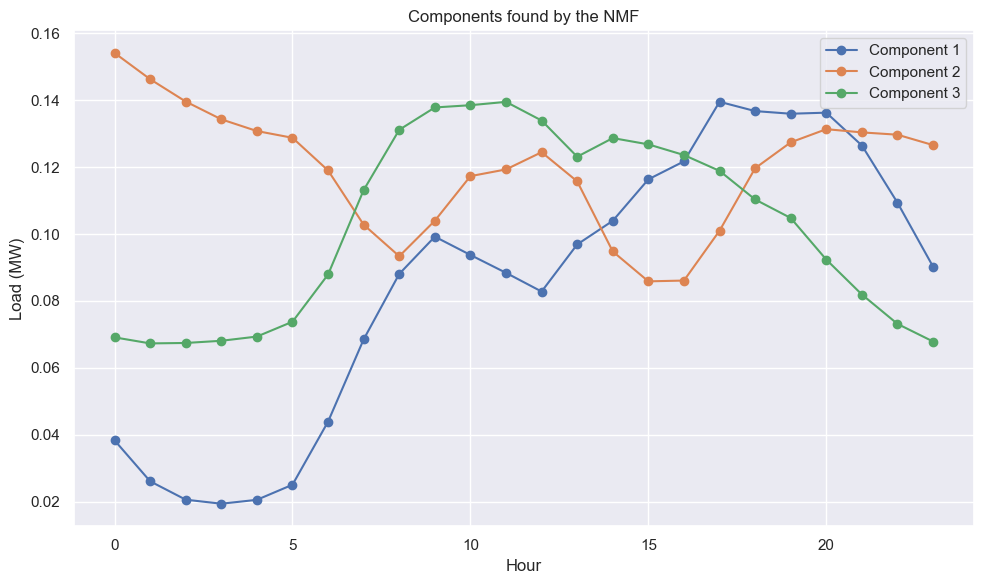

In [298]:
n_components = 3
random_state = None
tol = 1e-5
init = 'random'
max_iter = 4000
solver = 'mu'

fig, axs = plt.subplots(1, 1, figsize=(10, 6))

model = NMF(
    n_components=n_components,
    random_state=random_state,
    solver=solver,
    tol=tol,
    init=init,
    max_iter=max_iter
)

W = model.fit_transform(X)
H = model.components_

print('{} iterations'.format(model.n_iter_))
print('{} error'.format(model.reconstruction_err_/X.size))
plot_components(H, ax=axs, title=f"Components found by the NMF")

plt.tight_layout()

## Initialization with year level sector-wise consumption

### Run NMF

520 iterations
1.0110042569887314e-05 error


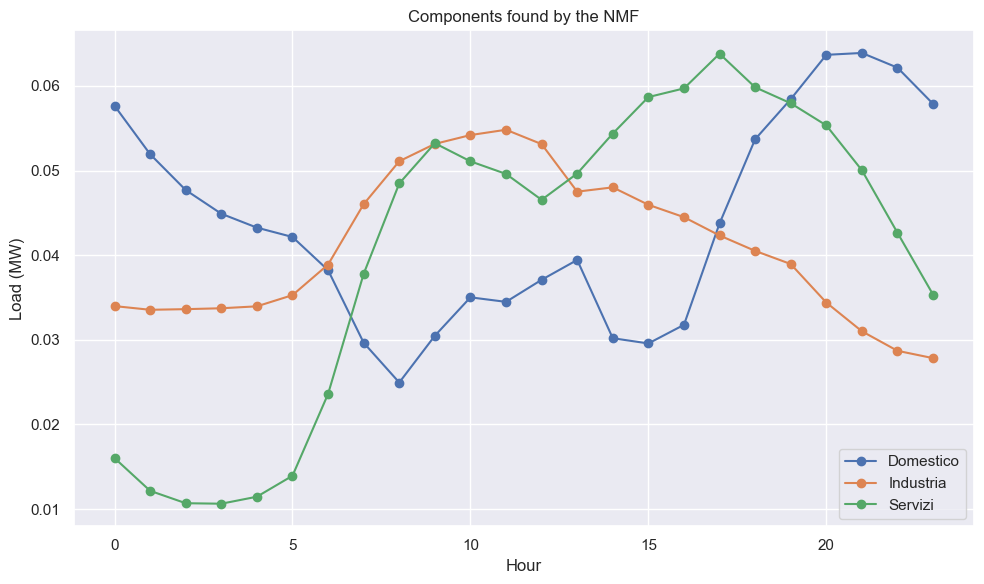

In [299]:
n_components = 3
random_state = None
tol = 1e-5
init = 'custom'
max_iter = 4000
solver = 'mu'
verbose = 0

fig, axs = plt.subplots(1, 1, figsize=(10, 6))

model = NMF(
    n_components=n_components,
    random_state=random_state,
    solver=solver,
    tol=tol,
    init=init,
    max_iter=max_iter,
    verbose=verbose
)

W = model.fit_transform(
    X.values,
    W=W_init.values.copy(order='C'),
    H=H_init
)

H = model.components_

print('{} iterations'.format(model.n_iter_))
print('{} error'.format(model.reconstruction_err_/X.size))
plot_components(H, ax=axs, title=f"Components found by the NMF", component_names=W_init.columns)
plt.tight_layout()
plt.savefig('documents/plots/profiles/monthly/month{}_3_sectors_profiles.png'.format('-'.join(months)))

In [300]:
W = pd.DataFrame(W, index=df.index, columns=W_init.columns)
W[unit_info.columns] = df[unit_info.columns]
W

,Domestico,Industria,Servizi,region,year,month,daytype
Calabria_2021-12-01_Working day,0.502620,0.284822,0.194495,Calabria,2021,12,Working day
Calabria_2021-12-02_Working day,0.237818,0.402968,0.363379,Calabria,2021,12,Working day
Calabria_2021-12-03_Working day,0.337721,0.525335,0.130400,Calabria,2021,12,Working day
Calabria_2021-12-04_Saturday,0.214799,0.781911,0.003403,Calabria,2021,12,Saturday
Calabria_2021-12-05_Holiday,0.178714,0.508628,0.321365,Calabria,2021,12,Holiday
...,...,...,...,...,...,...,...
South_2022-12-27_Working day,0.243537,0.228567,0.534141,South,2022,12,Working day
South_2022-12-28_Working day,0.190627,0.038620,0.784377,South,2022,12,Working day
South_2022-12-29_Working day,0.275010,0.424216,0.302162,South,2022,12,Working day
South_2022-12-30_Working day,0.328079,0.103685,0.570632,South,2022,12,Working day


In [301]:
region_cons_df

Settore corretto,Domestico,Industria,Servizi
Zone,,,
Calabria,0.418757,0.169124,0.412119
Centre.North,0.227537,0.456270,0.316193
Centre.South,0.296825,0.311082,0.392093
North,0.183974,0.520047,0.295979
Sardinia,0.287522,0.439368,0.273110
Sicily,0.342059,0.353885,0.304057
South,0.255487,0.467103,0.277410


In [302]:
W_region = W.groupby('region')[['Domestico', 'Industria', 'Servizi']].sum()
W_region = W_region.div(W_region.sum(axis=1), axis=0)
W_region

,Domestico,Industria,Servizi
region,,,
Calabria,0.275501,0.422938,0.301561
Centre.North,0.212605,0.477662,0.309733
Centre.South,0.288103,0.329448,0.382450
North,0.195303,0.491132,0.313566
Sardinia,0.310084,0.448095,0.241821
Sicily,0.360357,0.296800,0.342843
South,0.321667,0.337055,0.341278


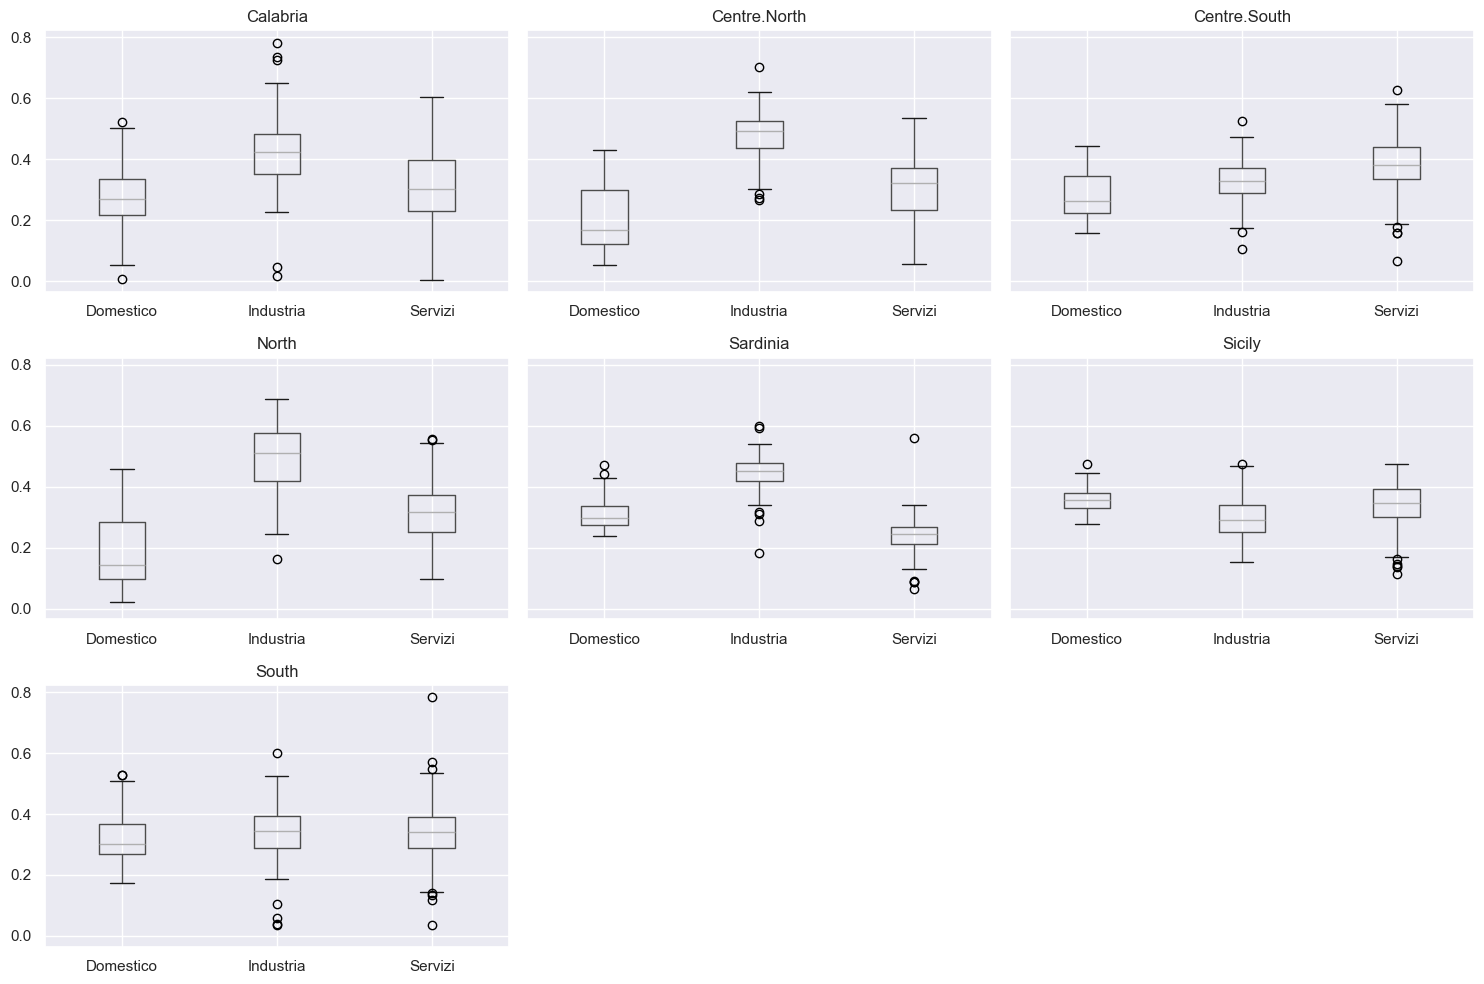

In [303]:
W.groupby('region')[['Domestico', 'Industria', 'Servizi']].boxplot(figsize=(15,10))
plt.tight_layout()

In [304]:
W_daytype = W.groupby('daytype')[['Domestico', 'Industria', 'Servizi']].sum()
W_daytype = W_daytype.div(W_daytype.sum(axis=1), axis=0)
W_daytype

,Domestico,Industria,Servizi
daytype,,,
Holiday,0.389455,0.361435,0.249111
Saturday,0.322702,0.420152,0.257146
Working day,0.237480,0.406682,0.355838


In [305]:
W_daytype = W[W['daytype'] == 'Working day'].groupby(['region', 'month'])[['Domestico', 'Industria', 'Servizi']].sum()
W_daytype = W_daytype.div(W_daytype.sum(axis=1), axis=0).round(2)
# W_daytype
W_daytype.unstack(level='region').T

month                     12
          region            
Domestico Calabria      0.26
          Centre.North  0.15
          Centre.South  0.24
          North         0.12
          Sardinia      0.29
          Sicily        0.34
          South         0.28
Industria Calabria      0.41
          Centre.North  0.49
          Centre.South  0.34
          North         0.52
          Sardinia      0.45
          Sicily        0.29
          South         0.35
Servizi   Calabria      0.33
          Centre.North  0.36
          Centre.South  0.42
          North         0.36
          Sardinia      0.26
          Sicily        0.37
          South         0.37

___

# Tests